### This jupyter note book include scripts
- Usage of ploting kaplan meier plot through two packages: lifeline and sckit-survival
- Data source from created Synthea csv file and handcrafted test data

##### Part 1: Double curve in Kaplan Meier plot 
##### Part 2: Handcrafted regression extreme test data for Kaplan Meier plot 

Note: store the Synthea patients.csv, mediactions.csv and conditions.csv under the folder csv

In [1]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from datetime import datetime
import lifelines
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
import plotly as py
import plotly.tools as tls   
from plotly.graph_objs import *
from pylab import rcParams
rcParams['figure.figsize']=10, 5
from sksurv.nonparametric import kaplan_meier_estimator


## Part 1
### Double curve in Kaplan Meier plot 

1. Below utilize lifelines and sckit-survival to do a simple survival analysis 
2. Assume: data is right-censored which means must have start time but may incomplete data with missing stop time
3. Example data:
- condition: Maglinant neoplasm of the breast (disorder)
- medication 1: paclitaxel 100 mg injection 
- medication 2: 100ml epirubicin hydrochloride 2mg/ml injection


**Steps** for Kaplan Meier analysis(survival probability vs time-to-event)
1. Get the time range for the Kaplan Meier analysis
2. Clinical outcome (alive or death) is used to get the end time and status, if alive then the end time is the end time of the Kaplan Meier analysis
3. Get start time form <span style="color:grey"> condition </span> table (data must have start time)
4. Get end time from <span style="color:grey"> patient </span> table (DEATHDATE)
5. Change the type of date form string to datetime and compute time difference(duration)
6. Then compute duration and get the data with columns: duration, status, group(medication used)
7. Use KaplanMeierFitter() to for lifelines or kaplan_meier_estimator() for sckit-survival and plot graph.


In [72]:
# the function is used to get the data including (time_to_event, status) can be pluged into kaplanmeier estimator
def get_standard_format_medication(Medications,Patient,Conditions,chosen_condition,chosen_medication,survival_analysis_endtime):
    '''
    Patient: dataframe for the patient.csv in Synthea format
    Conditions: dataframe for the conditions.csv in Synthea format
    Medications: dataframe for the medication.csv in Synthea format
    chosen_medication: list of medication chosen 
    chosen_condition: list of condition chosen, the cohort of patient need to diagonized with the condition and only medication with the reason as the one of the condition will be selected, but if the list is empty then all the data will be imported to database
    survival_analysis_endtime: datatime object of the endtime of survival analysis
    '''
# get the all medication information for the selected condition patients
    Medications['DESCRIPTION'] = Medications['DESCRIPTION'].apply(lambda x: x.lower())
    date_format = "%Y-%m-%d"


    # condition on the condition(cancer type) and medication
    selected_Conditions = Conditions[Conditions['CODE'].isin(chosen_condition)]

    selected_Medications = Medications[Medications['CODE'].isin(chosen_medication)]

    # join the medication and condition information
    selected_data = selected_Conditions.merge(selected_Medications, how='inner', left_on=['PATIENT', 'CODE'], right_on=['PATIENT', 'REASONCODE'],suffixes=['_condition','_medication'])

    # change to datetime type for time informatio
    selected_data['START_medication'] = selected_data['START_medication'].apply(lambda row :row.replace('/','-')if (type(row)==str) else row)
    selected_data['START_medication'] = selected_data['START_medication'].apply(lambda row : datetime.strptime(str(row)[:10],date_format) if (type(row)==str) else 'not defined' )
    selected_data['START_condition'] = selected_data['START_condition'].apply(lambda row :row.replace('/','-')if (type(row)==str) else row)
    selected_data['START_condition'] = selected_data['START_condition'].apply(lambda row : datetime.strptime(str(row)[:10],date_format) if (type(row)==str) else 'not defined' )
    
    # get the earliest_medication_starttime for the two medicine for each patient
    earliest_medication_starttime = selected_data.groupby(['PATIENT','CODE_medication','START_condition'])['START_medication'].min().reset_index(name='earliest_medication_starttime')
   
    # we only select case that for the patient only take one of the drug
    number_type_drug_took = earliest_medication_starttime.groupby('PATIENT').size().reset_index(name='type_drug_counts')
    # get list of patient took both drug
    patient_took_both_drug = list(number_type_drug_took.loc[number_type_drug_took.type_drug_counts>1].PATIENT)
    # remove patient that took both drug
    earliest_medication_starttime = earliest_medication_starttime[~earliest_medication_starttime['PATIENT'].isin(patient_took_both_drug)]

    
    # join with patient.csv to get deathdate information
    selected_data = Patient.merge(earliest_medication_starttime, how='inner', left_on=['Id'], right_on=['PATIENT'])
    

    #get status for the event(death as 1, alive as 0)
    selected_data['status'] = selected_data['DEATHDATE'].apply(lambda row : 1 if (type(row)==str) else 0 )
    selected_data['start_time'] = selected_data['earliest_medication_starttime']
    
    # data must have start_time
    selected_data = selected_data[selected_data['start_time'].notna()]
  

    #get end_time for events( if alive then use the survival_analysis_endtime else use the deathtime
    selected_data['DEATHDATE'] = selected_data['DEATHDATE'].apply(lambda row :row.replace('/','-')if (type(row)==str) else row)
    
    selected_data['end_time'] = selected_data['DEATHDATE'].apply(lambda row : datetime.strptime(str(row)[:10],date_format) if (type(row)==str) else survival_analysis_endtime)
    selected_data['time'] = (selected_data['end_time'] - selected_data['start_time'])
    selected_data['BIRTHDATE'] = selected_data['BIRTHDATE'].apply(lambda row :row.replace('/','-')if (type(row)==str) else row)
    selected_data['BIRTHDATE'] = selected_data['BIRTHDATE'].apply(lambda row : datetime.strptime(str(row)[:10],date_format) if (type(row)==str) else 'not defined' )
    selected_data['Age_cancer'] = (selected_data['START_condition'] - selected_data['BIRTHDATE'])
    selected_data['Age_cancer'] = round(selected_data['Age_cancer'].dt.days/365)
    

    return selected_data

In [3]:

# Data used
Medications = pd.read_csv("../csv/medications.csv")
Patient = pd.read_csv("../csv/patients.csv")
Conditions = pd.read_csv("../csv/conditions.csv")

chosen_medication = [1732186,583214]
# chosen_medication = ['100 ML Epirubicin Hydrochloride 2 MG/ML Injection':'1732186','Paclitaxel 100 MG Injection':'583214']
# chosen_condition = ['Malignant neoplasm of breast (disorder)':254837009]
chosen_condition = [254837009]

date_format = "%Y-%m-%d"
survival_analysis_endtime = datetime.strptime('2023-1-21',date_format)
selected_data = get_standard_format_medication(Medications,Patient,Conditions,chosen_condition,chosen_medication,survival_analysis_endtime)

In [93]:
#selected_data
    

In [5]:
# two function to realize Kaplan Meier plot with two package, result in same plot
# reference:https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html
# this function use lifelines package to draw kaplan meier curve
def get_kaplan_meier_plot1(standard_format,duration_unit = 'Years'):
    '''
    standard_format: dataframe with columns time status and group used for kaplan meier curve
    duration_unit: the unit shown in the x-axs for kaplan meier curve, default as Year
    '''
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    
    if(duration_unit == 'Days'):
        standard_format['time'] = standard_format['time'].dt.days
    elif(duration_unit == 'Months'):
        standard_format['time'] = standard_format['time'].dt.days/30
    elif(duration_unit == 'Years'):
        standard_format['time'] = standard_format['time'].dt.days/365
     
    # ref https://buildmedia.readthedocs.org/media/pdf/lifelines/latest/lifelines.pdf
    for name, grouped_df in standard_format.groupby('group'): 
        
        kmf.fit(grouped_df["time"], grouped_df["status"], label=name) 
        # to get calculated probability and 
        #print(kmf.survival_function_)
        kmf.plot_survival_function(
            ax=ax,
            show_censors=True,
            censor_styles={'ms': 8, 'marker': '+', 'markeredgecolor': '#ff0000' }, 
    
            ci_show=True)

    ax.set_xlabel("duration, in "+duration_unit)   
    ax.set_ylabel("Survival probability") 
    ax.set_title("Kaplan Meier plot") 
    ax.set_xlim((0, max(standard_format.time)+(max(standard_format.time)+1)/10)) 
    ax.set_ylim(0, 1.1) 
    ax.legend(loc="best")

    kmf2 = plt.gcf()


# this function use sckit-survival package to draw kaplan meier curve
def get_kaplan_meier_plot2(standard_format,duration_unit = 'Years'):
    '''
    standard_format: dataframe with columns time status and group used for kaplan meier curve
    duration_unit: the unit shown in the x-axs for kaplan meier curve, default as Year
    '''
    ax = plt.subplot(111)
    for name, grouped_df in standard_format.groupby('group'): 
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(grouped_df["status"],grouped_df["time"])
        
        # for function in scikit-survival, it do not plot the start survival at prob 1 we add it manually so to get same plot as result from lifelines 
        time_treatment = np.insert(time_treatment, 0, 0, axis=0)
        survival_prob_treatment = np.insert(survival_prob_treatment, 0, 1.0, axis=0)
        
        if(int(max(grouped_df.time)) == 0 ):
            plt.step(time_treatment, survival_prob_treatment, where="post",lw = 5,label="%s "  % name)
        else:
            plt.step(time_treatment, survival_prob_treatment, where="post",label="%s "  % name)
        
    ax.set_xlabel("duration, in "+duration_unit)   
    ax.set_ylabel("Survival probability") 
    ax.set_title("Kaplan Meier plot") 
    ax.set_xlim((0, max(standard_format.time)+(max(standard_format.time)+1)/10)) 
    ax.set_ylim(0, 1.1)
    ax.legend(loc="best")
    # plt.rcParams["figure.figsize"] = (7,7) 
  

In [94]:

# selected_data =selected_data.rename(columns = {'CODE_medication':'group'})
# standard_format = selected_data[['Id','time','status','group']]
# standard_format.group = standard_format.group.map({1732186: '100 ML Epirubicin Hydrochloride 2 MG/ML Injection',583214:'Paclitaxel 100 MG Injection'})
# standard_format

,Id,time,status,group
0,891c8475-0b92-2b98-bc69-32ae5e069821,3362 days,0,Paclitaxel 100 MG Injection
1,b526681b-ad04-f136-887c-f8ad4b37b288,531 days,0,100 ML Epirubicin Hydrochloride 2 MG/ML Injection
2,0983c162-60e8-ef34-712c-045875c66164,390 days,1,Paclitaxel 100 MG Injection
3,39df748d-1ead-461d-5ed5-54fa622396f1,3066 days,0,Paclitaxel 100 MG Injection
4,1307daef-336c-05c5-3830-f6a5388da4ee,3683 days,0,Paclitaxel 100 MG Injection
5,9e9047d5-4f5e-dbc8-2dae-b2b43a6246ae,816 days,0,Paclitaxel 100 MG Injection
6,b974042c-5140-fb7e-8ac3-ddd62d8bd801,3135 days,1,Paclitaxel 100 MG Injection
7,71d99b97-f1ff-579f-a626-619ad77fda13,3262 days,1,Paclitaxel 100 MG Injection
8,7fe0a247-811b-fc51-4e15-ce39e06c2394,823 days,0,Paclitaxel 100 MG Injection
9,483ae6d2-0ae6-e8ec-4eed-5ce2a4a64143,1249 days,1,Paclitaxel 100 MG Injection


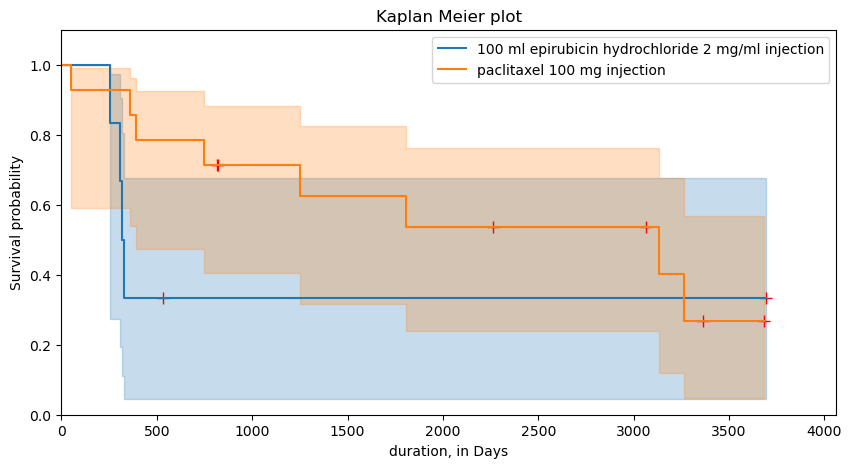

In [7]:
selected_data =selected_data.rename(columns = {'DESCRIPTION_medication':'group'})
standard_format = selected_data[['Id','time','status','group']]
standard_format
get_kaplan_meier_plot1(standard_format,duration_unit = 'Days')



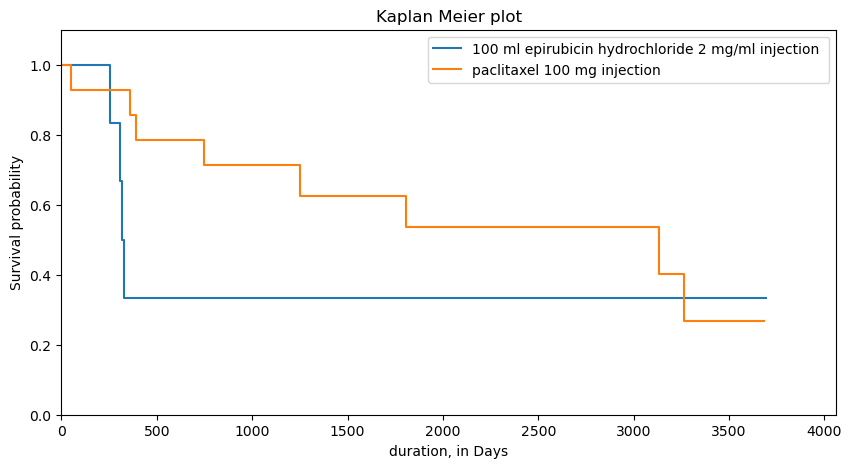

In [8]:
standard_format.status = standard_format.status.map({0: False, 1: True})
get_kaplan_meier_plot2(standard_format,duration_unit = 'Days')



#### Logrank test is used to test the whether there is a signicant statistical effect of one variable on the survival time
- Non-parametrs hypothesis test
- The null hypothesis is there is no significant influence and if the p value smaller than a predefiend value(normally 0.05)then we reject the hypothesis to state the variable has a significant statistical effect on the survival time
- the paramter putting in the logrank_test function in the lifelines library are: duration in category 1, duration in category 2, event status in category 1, event status  in category 2
- if the comparision is more than 2 group, use pairwise_logrank_test() or multivariate_logrank_test()

In [9]:
from lifelines.statistics import logrank_test

# the function to get logrank test output
def get_logrankTest_pvalue(standard_format):
    '''
    standard_format: dataframe with columns time status and group used for kaplan meier curve
    '''

    [group1_name,group2_name] = np.unique(standard_format.group)

    duration_1 = standard_format.loc[standard_format.group ==group1_name].time
    duration_2 = standard_format.loc[standard_format.group ==group2_name].time

    status_1 = standard_format.loc[standard_format.group ==group1_name].status
    status_2 = standard_format.loc[standard_format.group ==group2_name].status

    result = logrank_test(duration_1,duration_2,event_observed_A=status_1, event_observed_B=status_2)

    #result.print_summary()
    # 
    # extract the statistic information
    return round(result.p_value,6)
# result.test_statistic

In [10]:
print(get_logrankTest_pvalue(standard_format))
standard_format

0.225826


,Id,time,status,group
0,891c8475-0b92-2b98-bc69-32ae5e069821,3362,False,paclitaxel 100 mg injection
1,b526681b-ad04-f136-887c-f8ad4b37b288,531,False,100 ml epirubicin hydrochloride 2 mg/ml injection
2,0983c162-60e8-ef34-712c-045875c66164,390,True,paclitaxel 100 mg injection
3,39df748d-1ead-461d-5ed5-54fa622396f1,3066,False,paclitaxel 100 mg injection
4,1307daef-336c-05c5-3830-f6a5388da4ee,3683,False,paclitaxel 100 mg injection
5,9e9047d5-4f5e-dbc8-2dae-b2b43a6246ae,816,False,paclitaxel 100 mg injection
6,b974042c-5140-fb7e-8ac3-ddd62d8bd801,3135,True,paclitaxel 100 mg injection
7,71d99b97-f1ff-579f-a626-619ad77fda13,3262,True,paclitaxel 100 mg injection
8,7fe0a247-811b-fc51-4e15-ce39e06c2394,823,False,paclitaxel 100 mg injection
9,483ae6d2-0ae6-e8ec-4eed-5ce2a4a64143,1249,True,paclitaxel 100 mg injection


------

## Part 2
### Handcrafted regression extreme test data for Kaplan Meier plot 
- Test set A: All patients survive for 1 year
- Test set B: All patients survive 
- Test set C: All patients survive for 1 day
- Test set D: 1 patient survives for 1 year, 1 patient survives for 2 years,...., 1 patient survives for 10 years
- Set E: half of patient die after 5 years and half alive
- Test set g: two condition, one condition all alive another get 1 patient survives for 1 year, 1 patient survives for 2 years,...., 1 patient survives for 10 years

In [40]:
# the function is used to get standard format to do kaplan meier curve to compare survival time in different cancer diagnosed
def get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format,survival_analysis_endtime):
    """
    Patient: dataframe for the patient information in Synthea format
    Conditions: dataframe for the conditions information in Synthea format
    Medications: dataframe for the medication information in Synthea format
    chosen_condition: list of condition chosen that the cohort of patient need to diagonized with the condition and only medication with the reason as the one of the condition will be selected, but if the list is empty then all the data will be imported to database
    Time_format: string about the format that datetime stored in columns
    survival_analysis_endtime: datetime object which the end time of survival analysis
    """
    df = Conditions[Conditions['CODE'].isin(chosen_condition)]

    sample_with_info = df.reset_index().merge(Patient, left_on='PATIENT', right_on='Id',
                                          how='left', suffixes=['_km',''])
    df =sample_with_info[['PATIENT','START','STOP','GENDER','BIRTHDATE','DEATHDATE','CODE']]

    df = df[df['START'].notna()]

    # get start time and end time(death date) if alive then end time as undefined
    df['start_time'] = df['START'].apply(lambda row : datetime.strptime(str(row)[:10],Time_format)  )
    df['status'] = df['DEATHDATE'].apply(lambda row : 1 if (type(row)==str) else 0 )

    df['end_time'] = df['DEATHDATE'].apply(lambda row : datetime.strptime(str(row)[:10],Time_format) if (type(row)==str) else survival_analysis_endtime)
    

    df['time'] = (df['end_time'] - df['start_time'])
      
    
    return df

    

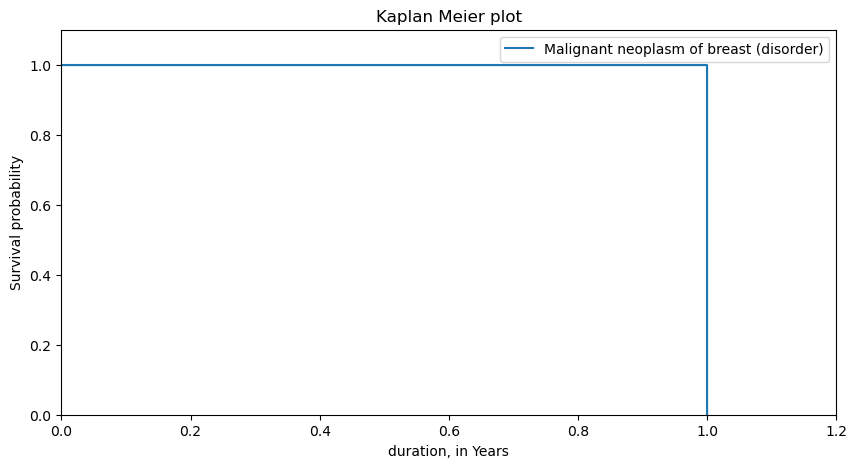

In [49]:
Patient = pd.read_csv("../Test Sets/Set A_All die in 1 year/patients.csv")
Conditions = pd.read_csv("../Test Sets/Set A_All die in 1 year/conditions.csv")

#chosen_condition = ['Malignant neoplasm of breast (disorder)']
chosen_condition = [254837009]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)'})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Years')



In [50]:
standard_format

,time,status,group
0,1.0,1,Malignant neoplasm of breast (disorder)
1,1.0,1,Malignant neoplasm of breast (disorder)
2,1.0,1,Malignant neoplasm of breast (disorder)
3,1.0,1,Malignant neoplasm of breast (disorder)
4,1.0,1,Malignant neoplasm of breast (disorder)
5,1.0,1,Malignant neoplasm of breast (disorder)
6,1.0,1,Malignant neoplasm of breast (disorder)
7,1.0,1,Malignant neoplasm of breast (disorder)
8,1.0,1,Malignant neoplasm of breast (disorder)
9,1.0,1,Malignant neoplasm of breast (disorder)


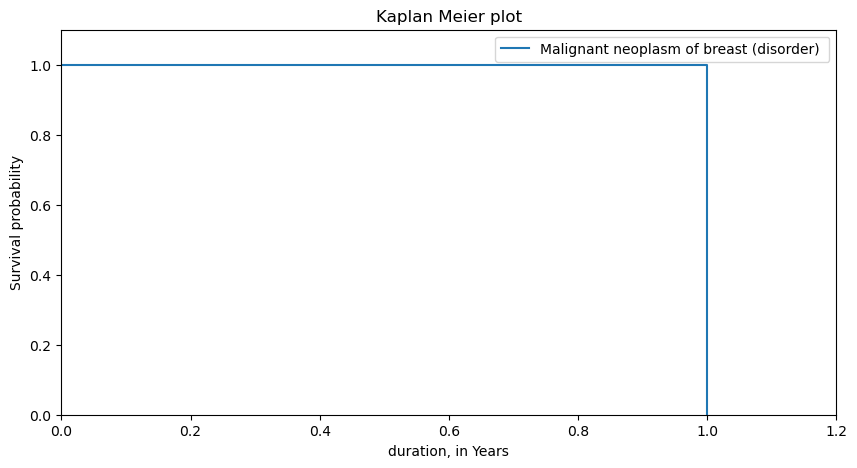

In [51]:
standard_format.status = standard_format.status.map({0: False, 1: True})
get_kaplan_meier_plot2(standard_format,duration_unit = 'Years')



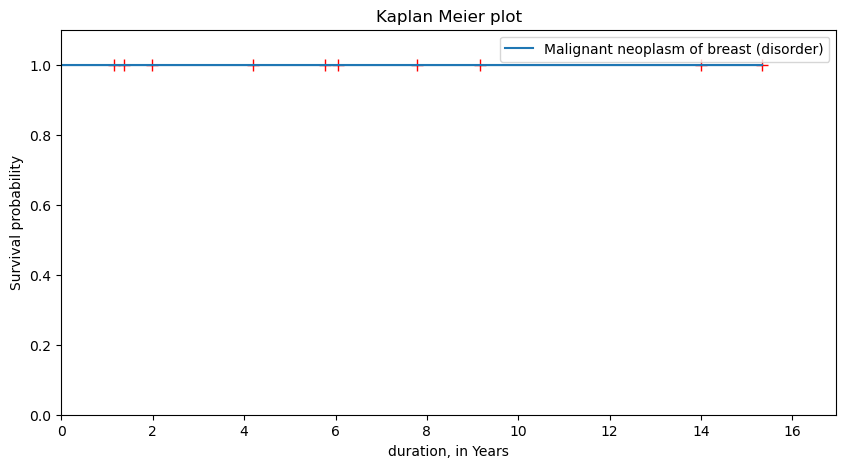

In [52]:
Patient = pd.read_csv("../Test Sets/Set B_ All alive/patients.csv")
Conditions = pd.read_csv("../Test Sets/Set B_ All alive/conditions.csv")

#chosen_condition = ['Malignant neoplasm of breast (disorder)']
chosen_condition = [254837009]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)'})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Years')



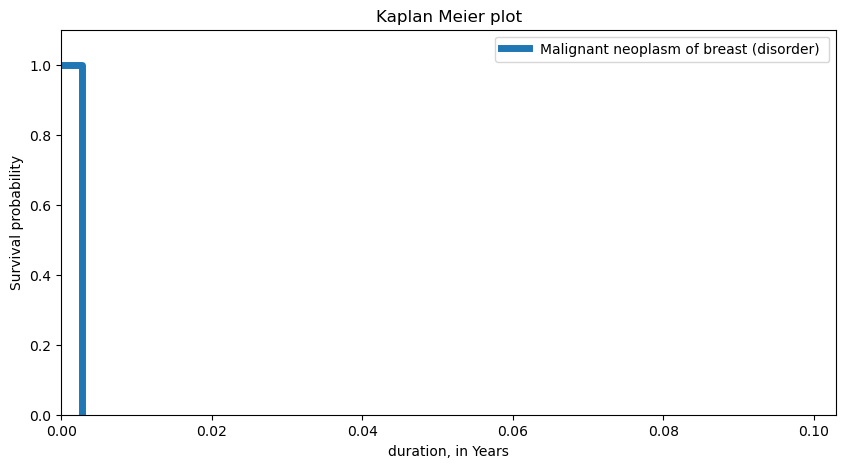

In [18]:
standard_format.status = standard_format.status.map({0: False, 1: True})
get_kaplan_meier_plot2(standard_format,duration_unit = 'Years')

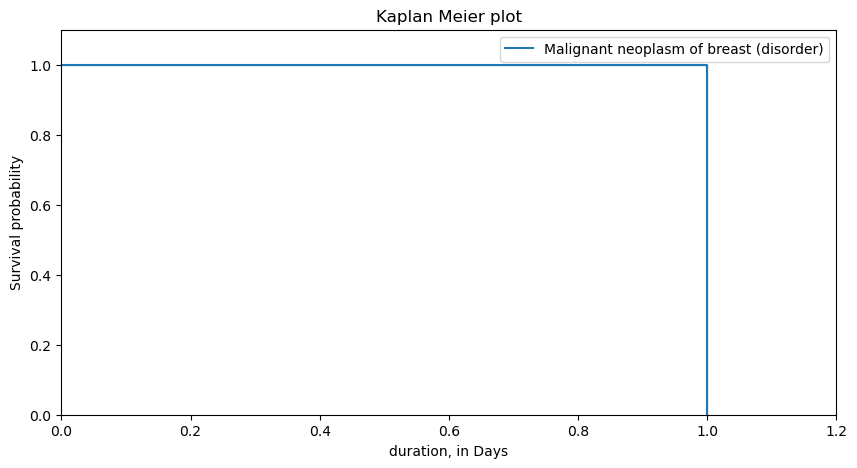

In [56]:
Patient = pd.read_csv("../Test Sets/Set C_All die in 1 day/patients.csv")
Conditions = pd.read_csv("../Test Sets/Set C_All die in 1 day/conditions.csv")


#chosen_condition = ['Malignant neoplasm of breast (disorder)']
chosen_condition = [254837009]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)'})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Days')



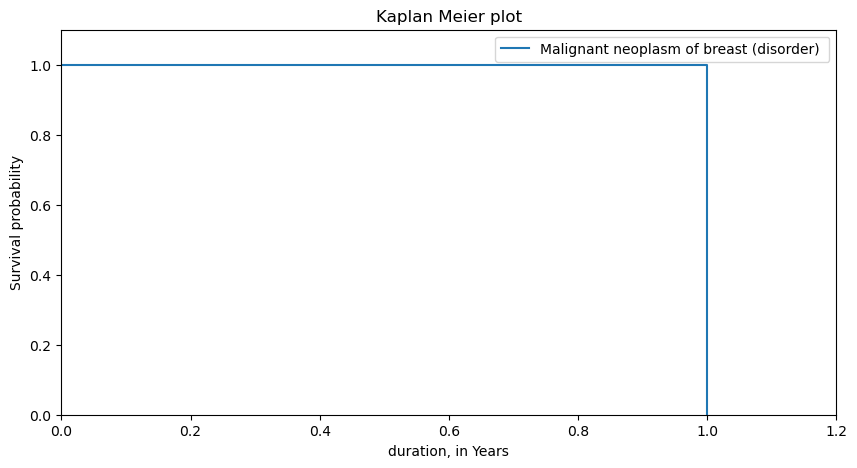

In [20]:
standard_format.status = standard_format.status.map({0: False, 1: True})
get_kaplan_meier_plot2(standard_format,duration_unit = 'Years')

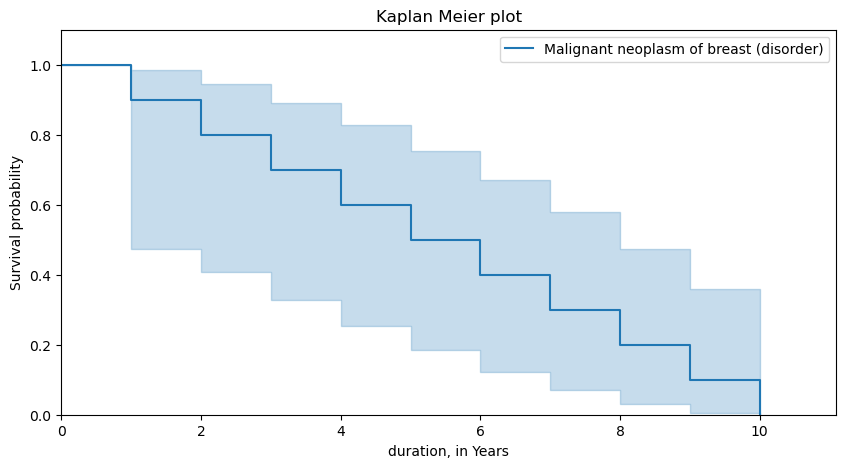

In [57]:
Patient = pd.read_csv("../Test Sets/Set D_All 1 year after each other(Staircase)/patients.csv")
Conditions = pd.read_csv("../Test Sets/Set D_All 1 year after each other(Staircase)/conditions.csv")

#chosen_condition = ['Malignant neoplasm of breast (disorder)']
chosen_condition = [254837009]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)'})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Years')



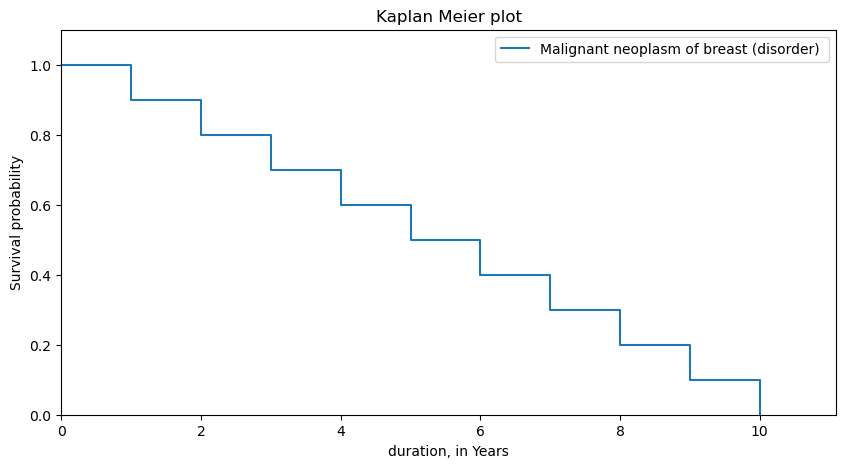

In [58]:
standard_format.status = standard_format.status.map({0: False, 1: True})
get_kaplan_meier_plot2(standard_format,duration_unit = 'Years')

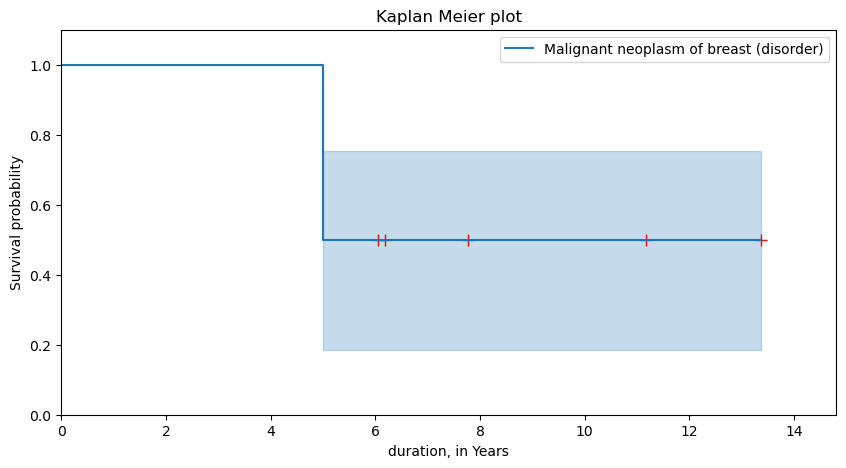

In [59]:
Patient = pd.read_csv("../Test Sets/Set E_50% die in 5 years/Patients.csv")
Conditions = pd.read_csv("../Test Sets/Set E_50% die in 5 years/conditions.csv")

#chosen_condition = ['Malignant neoplasm of breast (disorder)']
chosen_condition = [254837009]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)'})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Years')

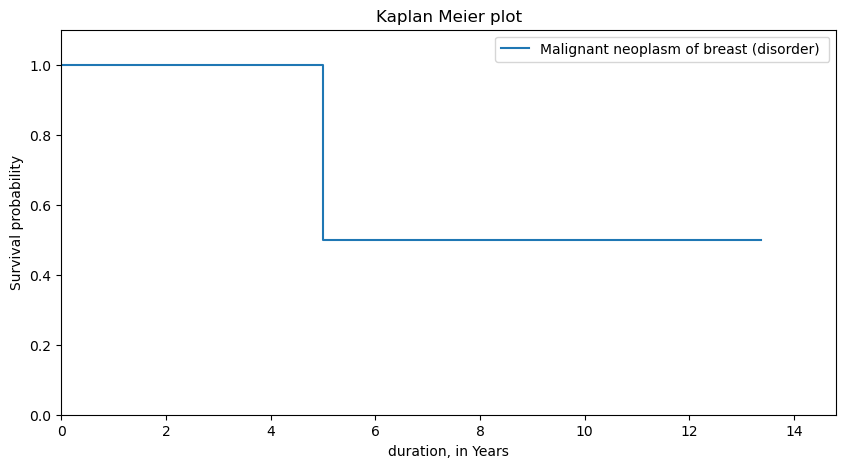

In [23]:
standard_format.status = standard_format.status.map({0: False, 1: True})
get_kaplan_meier_plot2(standard_format,duration_unit = 'Years')

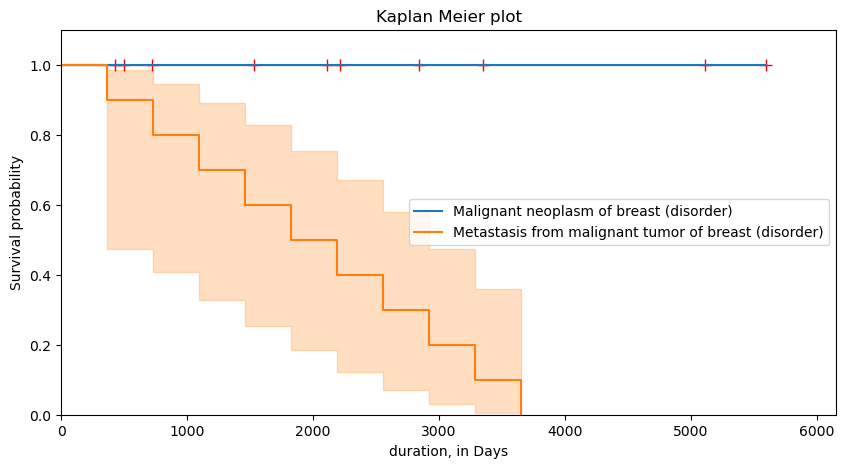

In [60]:
Patient = pd.read_csv("../Test Sets/two_conditions/Patients_g.csv")
Conditions = pd.read_csv("../Test Sets/two_conditions/conditions_g.csv")
#chosen_condition = ["Malignant neoplasm of breast (disorder)","Metastasis from malignant tumor of breast (disorder)"]

chosen_condition = [254837009,315004001]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)',315004001:"Metastasis from malignant tumor of breast (disorder)"})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Days')

## Example to put logranktest and KM curve together

In [63]:


# two function to realize Kaplan Meier plot with two package, result in same plot

# this function use lifelines package
def get_kaplan_meier_plot(standard_format,duration_unit = 'Years'):
    '''
    standard_format: dataframe with columns time status and group used for kaplan meier curve
    duration_unit: the unit shown in the x-axs for kaplan meier curve, default as Year
    '''
    
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    
    if(duration_unit == 'Days'):
        standard_format['time'] = standard_format['time'].dt.days
    elif(duration_unit == 'Months'):
        standard_format['time'] = standard_format['time'].dt.days/30
    elif(duration_unit == 'Years'):
        standard_format['time'] = standard_format['time'].dt.days/365
     
    # ref https://buildmedia.readthedocs.org/media/pdf/lifelines/latest/lifelines.pdf
    for name, grouped_df in standard_format.groupby('group'): 
        
        kmf.fit(grouped_df["time"], grouped_df["status"], label=name) 
        kmf.plot_survival_function(
            ax=ax,
            show_censors=True,
            censor_styles={'ms': 8, 'marker': '+', 'markeredgecolor': '#ff0000' }, 
            #color='dodgerblue',
            # at_risk_counts=True,
            ci_show=True)

    ax.set_xlabel("duration, in "+duration_unit)   
    ax.set_ylabel("Survival probability") 
    ax.set_title("Kaplan Meier plot") 
    ax.set_xlim((0, max(standard_format.time)+(max(standard_format.time)+1)/10)) 
    ax.set_xlim((0, max(standard_format.time)+(max(standard_format.time)+1)/10)) 
    ax.set_ylim(0, 1.1) 
    ax.legend(loc="best")

    if(len(np.unique(standard_format.group))==2):
        text_annotation_pos = max(standard_format.time)+(max(standard_format.time))/9
        
        
        pvalue = get_logrankTest_pvalue(standard_format)
        group1_name, group2_name = np.unique(standard_format.group)

        if pvalue<0.05:
            statement = f'they are statistically significant in this case'
        else:
            statement = f'they are not statistically significant in this case'
        ax.text(1, 0.1, f"LogRankTest pvalue:\n {pvalue}" , transform=ax.transData)
        ax.legend(loc="best")

        
    print( f"The pvalue for LogRankTest on comparison of survival probability for {group1_name} and {group2_name} is  {pvalue}, Hence " + statement)
    kmf2 = plt.gcf()    


In [74]:
Medications = pd.read_csv("../csv/medications.csv")
Patient = pd.read_csv("../csv/patients.csv")
Conditions = pd.read_csv("../csv/conditions.csv")

chosen_medication = [1732186,583214]
# chosen_medication = ['100 ML Epirubicin Hydrochloride 2 MG/ML Injection':'1732186','Paclitaxel 100 MG Injection':'583214']
# chosen_condition = ['Malignant neoplasm of breast (disorder)':254837009]
chosen_condition = [254837009]
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")
selected_data = get_standard_format_medication(Medications,Patient,Conditions,chosen_condition,chosen_medication,survival_analysis_endtime)

The pvalue for LogRankTest on comparison of survival probability for 100 ML Epirubicin Hydrochloride 2 MG/ML Injection and Paclitaxel 100 MG Injection is  0.225826, Hence they are not statistically significant in this case


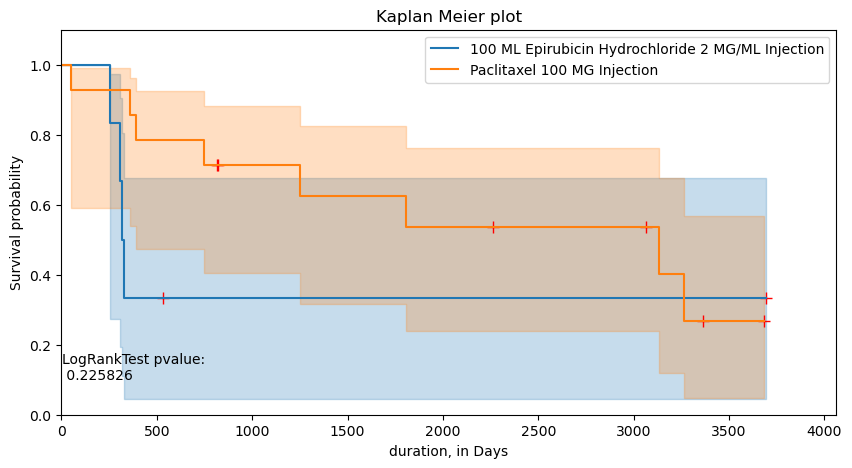

In [80]:
selected_data =selected_data.rename(columns = {'CODE_medication':'group'})
standard_format = selected_data[['Id','time','status','group']]
standard_format.group = standard_format.group.map({1732186: '100 ML Epirubicin Hydrochloride 2 MG/ML Injection',583214:'Paclitaxel 100 MG Injection'})
standard_format
get_kaplan_meier_plot(standard_format,duration_unit = 'Days')

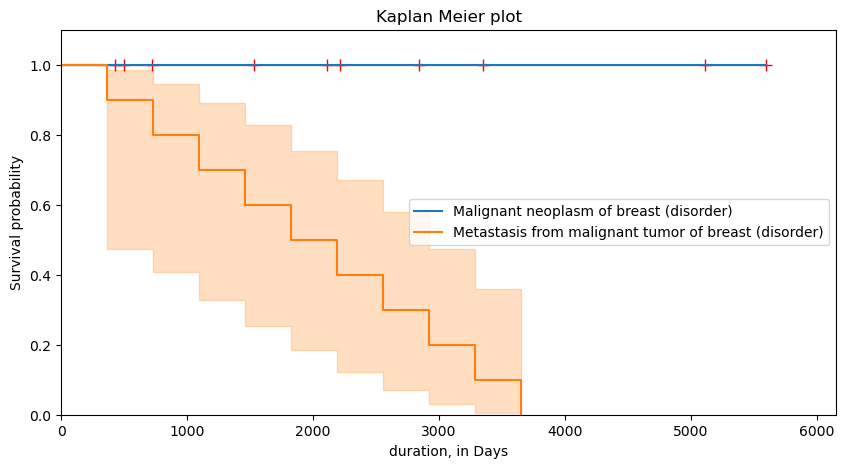

In [81]:
Patient = pd.read_csv("../Test Sets/two_conditions/Patients_g.csv")
Conditions = pd.read_csv("../Test Sets/two_conditions/conditions_g.csv")

chosen_condition = [254837009,315004001]
Time_format = "%d/%m/%Y"
survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")

standard_format = get_standard_format_Synthea_condition_case(Patient,Conditions,chosen_condition,Time_format, survival_analysis_endtime)
standard_format = standard_format[['time','status','CODE']].rename(columns = {'CODE':'group'})
standard_format.group = standard_format.group.map({254837009: 'Malignant neoplasm of breast (disorder)',315004001:"Metastasis from malignant tumor of breast (disorder)"})
get_kaplan_meier_plot1(standard_format,duration_unit = 'Days')

#### Cox Proportional Hazard Model for test significance of multiple variables
- Semi-Parametric

reference：https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d

In [91]:

# Data used
Medications = pd.read_csv("../csv/medications.csv")
Patient = pd.read_csv("../csv/patients.csv")
Conditions = pd.read_csv("../csv/conditions.csv")

chosen_medication = [1732186,583214]
# chosen_medication = ['100 ML Epirubicin Hydrochloride 2 MG/ML Injection':'1732186','Paclitaxel 100 MG Injection':'583214']
# chosen_condition = ['Malignant neoplasm of breast (disorder)':254837009]
chosen_condition = [254837009]

survival_analysis_endtime = datetime.strptime('2023/1/21',"%Y/%m/%d")
selected_data = get_standard_format_medication(Medications,Patient,Conditions,chosen_condition,chosen_medication,survival_analysis_endtime)

In [92]:
selected_data =selected_data.rename(columns = {'CODE_medication':'group'})
standard_format.group = standard_format.group.map({1732186: '100 ML Epirubicin Hydrochloride 2 MG/ML Injection',583214:'Paclitaxel 100 MG Injection'})
sample = selected_data[['time','status','group','Age_cancer']]
sample['time'] = sample['time'].dt.days
# we need to dummy code the group, notice remove one of the column https://www.databricks.com/notebooks/telco-accel/03_cox_proportional_hazards.html
sample = pd.get_dummies(sample,drop_first=True)

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(sample, duration_col = 'time', event_col = 'status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 20 total observations, 8 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 20
number of events observed = 12
   partial log-likelihood = -27.66
         time fit was run = 2023-02-21 23:28:22 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
group        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Age_cancer  -0.02       0.98       0.01            -0.05             0.00                 0.95                 1.00

             cmp to     z    p   -log2(p)
covariate                                
group          0.00  1.22 0.22       2.18
Age_cancer     0.00 -1.65 0.10       3.33
---
Concordance = 0.70
Partial AIC = 59.32
log-likelihood ratio test = 3.76 on 2 df
-log2(p) of ll-ratio test = 2.71